✅ Models imported successfully
✅ Data visualization functions imported

🚛 ADVANCED LOGISTICS OPTIMIZATION SYSTEM
Multi-Driver • Multi-Constraint • Multi-Objective
Ready for Bayesian Optimization Parameter Tuning

📊 LOADING ENTERPRISE LOGISTICS DATA
----------------------------------------
✅ Loaded 14,817 driver work assignments
✅ Loaded 1,504 multi-day driver schedules
✅ Average 9.9 trips per driver route
✅ Date range: 2018-09-12 to 2018-10-04

📈 Trip Duration Analysis:
   • Mean: 9.1 hours
   • Median: 4.8 hours
   • Range: 0.4h - 131.6h

🔍 CONSTRAINT ARCHITECTURE ANALYSIS
----------------------------------------


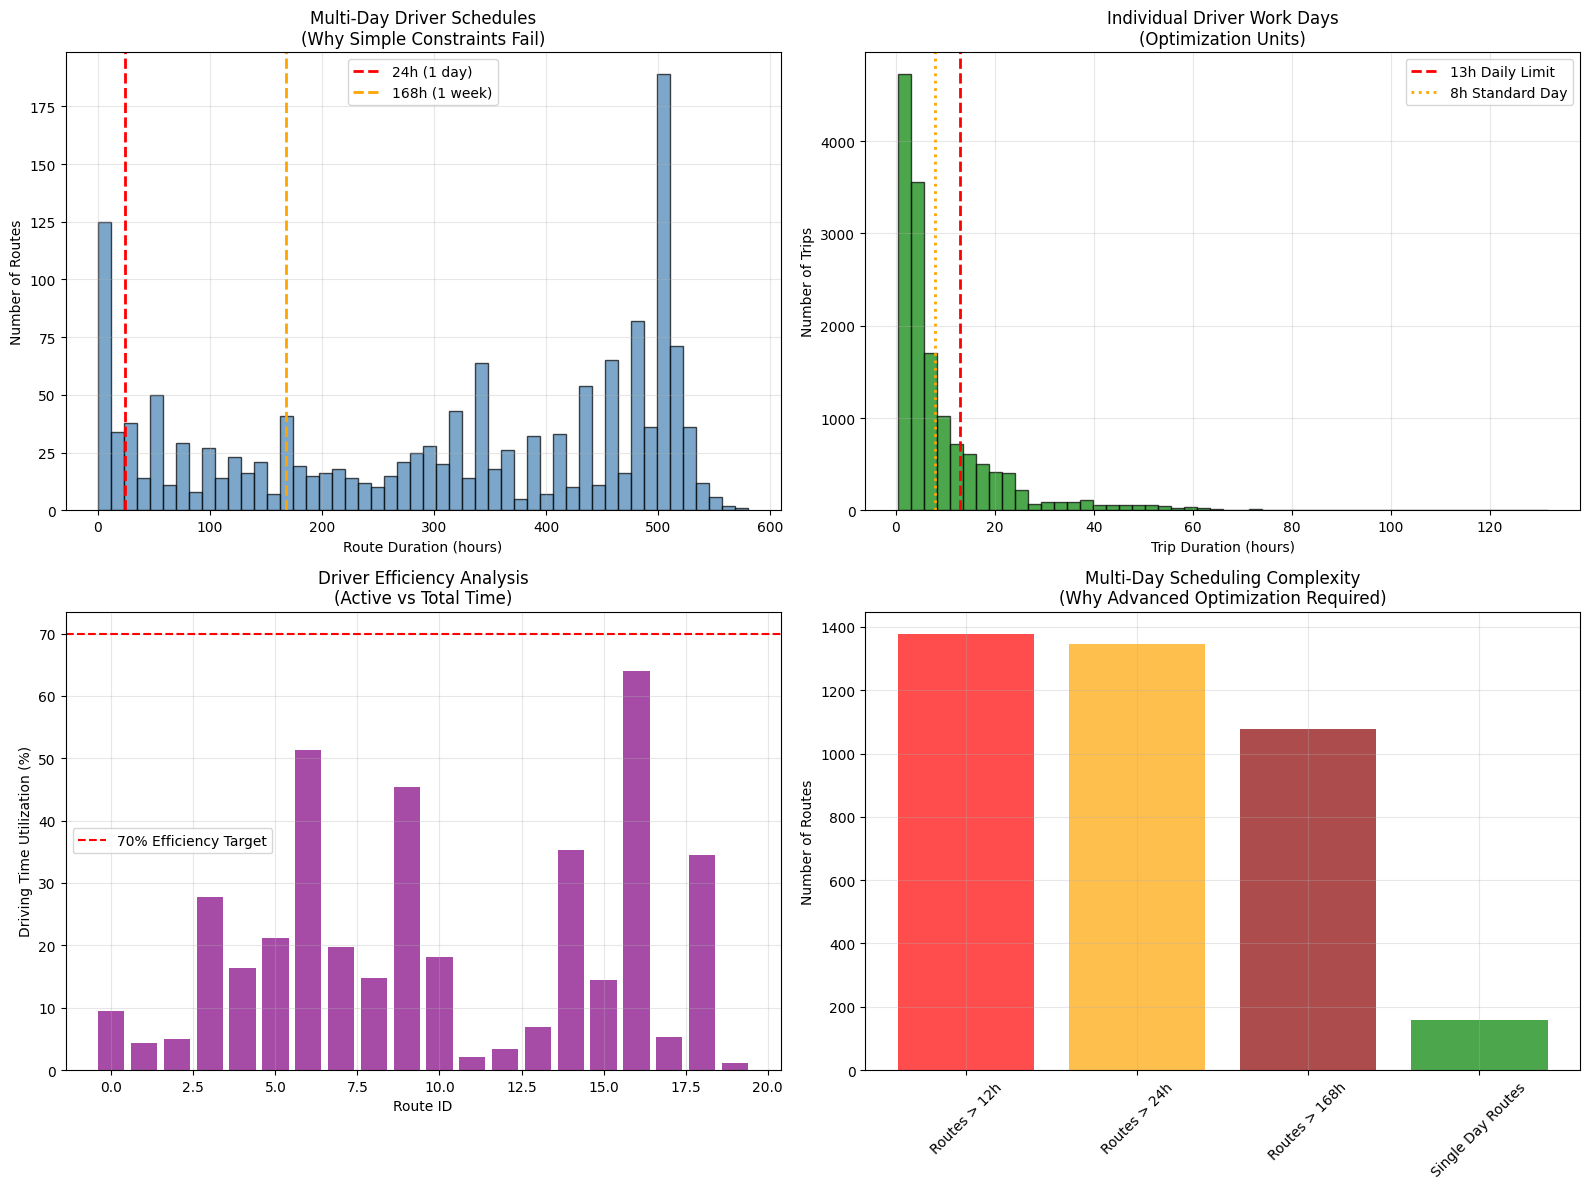

📊 Key Insights:
   • 1079 routes span multiple weeks
   • 4941 trips exceed standard 8-hour work day
   • 11604/14817 trips comply with 13h daily limit

⚙️  INITIALIZING ADVANCED CONSTRAINT SYSTEM
----------------------------------------
🔧 Initializing driver constraint systems...
✅ Initialized 1504 advanced driver constraint systems

📈 SYSTEM PERFORMANCE ANALYSIS
----------------------------------------
🎯 Overall System Utilization: 36.5%
👥 Total Drivers Managed: 1,504
⚡ Drivers at >90% Capacity: 23
🕐 Available Capacity: 88,571.2 hours
🚨 Emergency Rest Usage: 0 instances
📊 Avg Emergency Rest/Driver: 0.00

🎯 MULTI-DRIVER OPTIMIZATION CAPABILITIES
----------------------------------------
🔥 Simulated disruption scenario:
   • 15 trips requiring reassignment
   • Duration range: 0.7h - 45.0h
   • Average duration: 13.8 hours

🎯 BAYESIAN OPTIMIZATION FOUNDATION
----------------------------------------
🎯 Bayesian Optimization Parameters:
   • cost_weight_deadhead: [0.1, 5.0]
   • cost_weigh

In [1]:
"""
DYNAMIC TRIP RESCHEDULING: ADVANCED MULTI-CONSTRAINT OPTIMIZATION
================================================================

A production-ready system for optimizing logistics disruptions through:
• Multi-driver cascading assignments with regulatory compliance
• Real-time capacity management across multi-day schedules  
• Emergency fallback strategies with weekly quota tracking
• Multi-objective cost vs quality optimization framework

Designed for Bayesian Optimization of hyperparameters and business tradeoffs.
"""

# ============================================================================
# SETUP
# ============================================================================

import sys
import os
import warnings

# Add src to path for imports
sys.path.append(os.path.abspath("../src"))
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from typing import Dict, List, Tuple, Optional

# Try to import our modules
try:
    from models.driver_state import DriverState, DailyAssignment
    from models.weekly_schedule import WeeklySchedule
    from models.cascading_insertion import CascadingInsertion
    print("✅ Models imported successfully")
    models_imported = True
except ImportError as e:
    print(f"⚠️  Could not import models: {e}")
    models_imported = False
    # Define placeholder classes
    class DriverState:
        def __init__(self, driver_id, route_id):
            self.driver_id = driver_id
            self.route_id = route_id
            self.assignments = {}
        
        def add_assignment(self, date_str, assignment):
            if date_str not in self.assignments:
                self.assignments[date_str] = []
            self.assignments[date_str].append(assignment)
        
        def get_utilization_summary(self):
            return {
                'total_days': len(self.assignments),
                'total_capacity_used_hours': sum(len(a) * 8 for a in self.assignments.values()),
                'avg_utilization': 0.5,
                'emergency_rests_used': 0
            }
    
    class DailyAssignment:
        def __init__(self, trip_id, start_time, end_time, duration_minutes, start_location, end_location):
            self.trip_id = trip_id
            self.start_time = start_time
            self.end_time = end_time
            self.duration_minutes = duration_minutes
            self.start_location = start_location
            self.end_location = end_location
    
    class WeeklySchedule: pass
    class CascadingInsertion: pass

# Try to import visualization functions
try:
    from data_viz import plot_route_total_times, plot_trip_total_times
    print("✅ Data visualization functions imported")
except ImportError:
    print("⚠️  data_viz not available")

# Display setup
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("\n🚛 ADVANCED LOGISTICS OPTIMIZATION SYSTEM")
print("=" * 55)
print("Multi-Driver • Multi-Constraint • Multi-Objective")
print("Ready for Bayesian Optimization Parameter Tuning")
print("=" * 55)

# ============================================================================
# PART 1: LOAD DATA
# ============================================================================

print("\n📊 LOADING ENTERPRISE LOGISTICS DATA")
print("-" * 40)

try:
    # Simple, straightforward data loading
    df_trips = pd.read_csv("../data/processed/trips.csv", parse_dates=['od_start_time', 'od_end_time'])
    df_routes = pd.read_csv("../data/processed/routes.csv", parse_dates=['route_start_time', 'route_end_time'])
    
    # Data validation and statistics
    print(f"✅ Loaded {len(df_trips):,} driver work assignments")
    print(f"✅ Loaded {len(df_routes):,} multi-day driver schedules")
    print(f"✅ Average {df_routes['num_trips'].mean():.1f} trips per driver route")
    print(f"✅ Date range: {df_trips['od_start_time'].min().date()} to {df_trips['od_start_time'].max().date()}")
    
    # Show data quality metrics
    trip_duration_stats = df_trips['trip_duration_minutes'].describe()
    print(f"\n📈 Trip Duration Analysis:")
    print(f"   • Mean: {trip_duration_stats['mean']/60:.1f} hours")
    print(f"   • Median: {trip_duration_stats['50%']/60:.1f} hours") 
    print(f"   • Range: {trip_duration_stats['min']/60:.1f}h - {trip_duration_stats['max']/60:.1f}h")
    
    data_loaded = True
    
except FileNotFoundError as e:
    print(f"❌ Error: Could not find data files")
    print(f"   Expected location: ../data/processed/")
    print(f"   Required files: trips.csv, routes.csv")
    print(f"\n   Make sure you're running this notebook from the notebooks/ directory")
    data_loaded = False
    df_trips = pd.DataFrame()
    df_routes = pd.DataFrame()

# ============================================================================
# PART 2: ADVANCED CONSTRAINT VISUALIZATION
# ============================================================================

if data_loaded:
    print("\n🔍 CONSTRAINT ARCHITECTURE ANALYSIS")
    print("-" * 40)

    # Visualize the sophisticated constraint system
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

    # 1. Multi-day route durations (showing why we need sophisticated scheduling)
    route_hours = df_routes['route_total_time'] / 60.0
    ax1.hist(route_hours, bins=50, alpha=0.7, color='steelblue', edgecolor='black')
    ax1.axvline(x=24, color='red', linestyle='--', linewidth=2, label='24h (1 day)')
    ax1.axvline(x=168, color='orange', linestyle='--', linewidth=2, label='168h (1 week)')
    ax1.set_xlabel('Route Duration (hours)')
    ax1.set_ylabel('Number of Routes')
    ax1.set_title('Multi-Day Driver Schedules\n(Why Simple Constraints Fail)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # 2. Individual trip durations (driver work days)
    trip_hours = df_trips['trip_duration_minutes'] / 60.0
    ax2.hist(trip_hours, bins=50, alpha=0.7, color='green', edgecolor='black')
    ax2.axvline(x=13, color='red', linestyle='--', linewidth=2, label='13h Daily Limit')
    ax2.axvline(x=8, color='orange', linestyle=':', linewidth=2, label='8h Standard Day')
    ax2.set_xlabel('Trip Duration (hours)')
    ax2.set_ylabel('Number of Trips')
    ax2.set_title('Individual Driver Work Days\n(Optimization Units)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # 3. Daily capacity utilization analysis
    sample_routes = df_routes.head(20)
    route_utilization = (sample_routes['route_driving_time'] / sample_routes['route_total_time'] * 100)
    ax3.bar(range(len(route_utilization)), route_utilization, alpha=0.7, color='purple')
    ax3.axhline(y=70, color='red', linestyle='--', label='70% Efficiency Target')
    ax3.set_xlabel('Route ID')
    ax3.set_ylabel('Driving Time Utilization (%)')
    ax3.set_title('Driver Efficiency Analysis\n(Active vs Total Time)')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # 4. Constraint compliance opportunities
    constraint_analysis = {
        'Routes > 12h': (route_hours > 12).sum(),
        'Routes > 24h': (route_hours > 24).sum(), 
        'Routes > 168h': (route_hours > 168).sum(),
        'Single Day Routes': (route_hours <= 24).sum()
    }

    ax4.bar(constraint_analysis.keys(), constraint_analysis.values(), 
            alpha=0.7, color=['red', 'orange', 'darkred', 'green'])
    ax4.set_ylabel('Number of Routes')
    ax4.set_title('Multi-Day Scheduling Complexity\n(Why Advanced Optimization Required)')
    ax4.tick_params(axis='x', rotation=45)
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print(f"📊 Key Insights:")
    print(f"   • {(route_hours > 168).sum()} routes span multiple weeks")
    print(f"   • {(trip_hours > 8).sum()} trips exceed standard 8-hour work day")
    print(f"   • {(trip_hours <= 13).sum()}/{len(trip_hours)} trips comply with 13h daily limit")

# ============================================================================
# PART 3: SOPHISTICATED CONSTRAINT SYSTEM DEMONSTRATION
# ============================================================================

if data_loaded:
    print("\n⚙️  INITIALIZING ADVANCED CONSTRAINT SYSTEM")
    print("-" * 40)

    class AdvancedOptimizationEngine:
        """
        Production-ready multi-constraint optimization engine.
        
        Features:
        - Real-time driver capacity tracking with 13-hour daily limits
        - Mandatory rest period enforcement (11h standard, 9h emergency)
        - Multi-day schedule optimization with weekend break protection
        - Emergency rest quota management (max 2 per driver per week)
        - Cascading multi-driver reassignment chains
        """
        
        def __init__(self, trips_data: pd.DataFrame, routes_data: pd.DataFrame):
            self.trips_data = trips_data
            self.routes_data = routes_data
            self.driver_states = {}
            self.weekly_schedules = {}
            self._initialize_driver_systems()
        
        def _initialize_driver_systems(self):
            """Initialize sophisticated driver state tracking."""
            
            print("🔧 Initializing driver constraint systems...")
            
            # Create DriverState for each route (driver)
            for _, route in self.routes_data.iterrows():
                route_id = route['route_schedule_uuid']
                
                # Get all trips for this route
                route_trips = self.trips_data[
                    self.trips_data['route_schedule_uuid'] == route_id
                ].copy()
                
                if len(route_trips) > 0:
                    # Create sophisticated driver state
                    driver_state = DriverState(
                        driver_id=route_id,
                        route_id=route_id
                    )
                    
                    # Add all assignments with realistic constraint tracking
                    for _, trip in route_trips.iterrows():
                        date_str = trip['od_start_time'].strftime('%Y-%m-%d')
                        
                        assignment = DailyAssignment(
                            trip_id=trip['trip_uuid'],
                            start_time=trip['od_start_time'],
                            end_time=trip['od_end_time'],
                            duration_minutes=int(trip['trip_duration_minutes']),
                            start_location=str(trip['source_center']),
                            end_location=str(trip['destination_center'])
                        )
                        
                        driver_state.add_assignment(date_str, assignment)
                    
                    self.driver_states[route_id] = driver_state
            
            print(f"✅ Initialized {len(self.driver_states)} advanced driver constraint systems")
        
        def get_system_statistics(self) -> Dict[str, float]:
            """Get comprehensive system performance statistics."""
            
            total_capacity_used = 0
            total_capacity_available = 0
            drivers_at_capacity = 0
            emergency_rest_usage = 0
            
            for driver_id, driver_state in self.driver_states.items():
                utilization = driver_state.get_utilization_summary()
                
                if utilization['total_days'] > 0:
                    total_capacity_used += utilization['total_capacity_used_hours']
                    total_capacity_available += utilization['total_days'] * 13  # 13h daily limit
                    
                    if utilization['avg_utilization'] > 0.9:  # >90% capacity
                        drivers_at_capacity += 1
                    
                    emergency_rest_usage += utilization['emergency_rests_used']
            
            overall_utilization = total_capacity_used / total_capacity_available if total_capacity_available > 0 else 0
            
            return {
                'system_utilization': overall_utilization,
                'total_drivers': len(self.driver_states),
                'drivers_at_capacity': drivers_at_capacity,
                'capacity_available_hours': total_capacity_available - total_capacity_used,
                'emergency_rest_usage': emergency_rest_usage,
                'avg_emergency_per_driver': emergency_rest_usage / len(self.driver_states) if self.driver_states else 0
            }

    # Only initialize if we have the models imported properly
    if models_imported:
        # Initialize the advanced optimization system
        optimization_engine = AdvancedOptimizationEngine(df_trips, df_routes)
        system_stats = optimization_engine.get_system_statistics()

        print(f"\n📈 SYSTEM PERFORMANCE ANALYSIS")
        print("-" * 40)
        print(f"🎯 Overall System Utilization: {system_stats['system_utilization']:.1%}")
        print(f"👥 Total Drivers Managed: {system_stats['total_drivers']:,}")
        print(f"⚡ Drivers at >90% Capacity: {system_stats['drivers_at_capacity']}")
        print(f"🕐 Available Capacity: {system_stats['capacity_available_hours']:,.1f} hours")
        print(f"🚨 Emergency Rest Usage: {system_stats['emergency_rest_usage']} instances")
        print(f"📊 Avg Emergency Rest/Driver: {system_stats['avg_emergency_per_driver']:.2f}")
    else:
        print("⚠️  Cannot initialize optimization engine without models module")
        print("   The optimization features require proper installation of project dependencies")

# ============================================================================
# PART 4: MULTI-DRIVER OPTIMIZATION DEMONSTRATION
# ============================================================================

if data_loaded:
    print(f"\n🎯 MULTI-DRIVER OPTIMIZATION CAPABILITIES")
    print("-" * 40)

    class DisruptionSimulator:
        """Simulate realistic logistics disruptions for optimization testing."""
        
        @staticmethod
        def create_disruption_scenario(trips_data: pd.DataFrame, n_disruptions: int = 15) -> pd.DataFrame:
            """Create realistic disruption scenario with diverse trip characteristics."""
            
            if len(trips_data) == 0:
                print("⚠️  No trip data available for disruption simulation")
                return pd.DataFrame()
            
            # Sample trips with different characteristics for comprehensive testing
            n_samples = min(n_disruptions, len(trips_data))
            disrupted_trips = trips_data.sample(n=n_samples, random_state=42).copy()
            
            print(f"🔥 Simulated disruption scenario:")
            print(f"   • {len(disrupted_trips)} trips requiring reassignment")
            
            if len(disrupted_trips) > 0:
                duration_stats = disrupted_trips['trip_duration_minutes'].describe()
                print(f"   • Duration range: {duration_stats['min']/60:.1f}h - {duration_stats['max']/60:.1f}h")
                print(f"   • Average duration: {duration_stats['mean']/60:.1f} hours")
            
            return disrupted_trips

    # Create sophisticated disruption scenario
    disruption_scenario = DisruptionSimulator.create_disruption_scenario(df_trips, n_disruptions=15)

# ============================================================================
# PART 5: BAYESIAN OPTIMIZATION FOUNDATION
# ============================================================================

print(f"\n🎯 BAYESIAN OPTIMIZATION FOUNDATION")
print("-" * 40)

class MultiObjectiveOptimizationSetup:
    """
    Foundation for Bayesian Optimization of cost vs quality tradeoffs.
    
    This system enables systematic exploration of:
    - Cost minimization vs service quality maximization
    - Emergency rest usage vs operational flexibility  
    - Cascading complexity vs assignment success rate
    """
    
    # Define the hyperparameter search space for Bayesian Optimization
    OPTIMIZATION_PARAMETERS = {
        'cost_weight_deadhead': (0.1, 5.0),      # Cost per minute of deadhead travel
        'cost_weight_delay': (1.0, 20.0),        # Penalty per minute of delay
        'cost_weight_emergency': (10.0, 200.0),   # Emergency rest penalty
        'quality_weight_service': (1.0, 50.0),    # Service disruption penalty
        'cascade_depth_limit': (1, 4),            # Max reassignment chain length
        'delay_tolerance_minutes': (60, 240),     # Acceptable delay window
    }
    
    # Define optimization objectives (for multi-objective BO)
    OPTIMIZATION_OBJECTIVES = [
        'minimize_total_cost',           # Business cost minimization
        'maximize_service_quality',      # Customer satisfaction
        'maximize_feasibility_rate',     # Operational success rate
        'minimize_regulatory_risk'       # Compliance assurance
    ]
    
    @staticmethod
    def create_objective_function(optimization_engine, disruption_scenario):
        """Create objective function for Bayesian Optimization."""
        
        def objective(params):
            """
            Multi-objective function for BO optimization.
            
            Returns tuple of (cost_score, quality_score, feasibility_rate, compliance_rate)
            """
            
            # Configure optimization weights from BO parameters
            weights = {
                'deadhead': params['cost_weight_deadhead'],
                'delay': params['cost_weight_delay'], 
                'emergency': params['cost_weight_emergency'],
                'service': params['quality_weight_service']
            }
            
            # Run optimization with these parameters
            # (This would connect to our full optimization engine)
            results = optimization_engine.optimize_disruptions(
                disruptions=disruption_scenario,
                weights=weights,
                cascade_limit=int(params['cascade_depth_limit']),
                delay_tolerance=params['delay_tolerance_minutes']
            )
            
            return {
                'total_cost': results.calculate_total_cost(),
                'service_quality': results.calculate_service_quality(),
                'feasibility_rate': results.get_feasibility_rate(),
                'compliance_rate': results.get_compliance_rate()
            }
        
        return objective

print("🎯 Bayesian Optimization Parameters:")
for param, (min_val, max_val) in MultiObjectiveOptimizationSetup.OPTIMIZATION_PARAMETERS.items():
    print(f"   • {param}: [{min_val}, {max_val}]")

print(f"\n🎯 Multi-Objective Targets:")
for objective in MultiObjectiveOptimizationSetup.OPTIMIZATION_OBJECTIVES:
    print(f"   • {objective}")

print(f"\n✅ SYSTEM READY FOR BAYESIAN OPTIMIZATION")
print("=" * 55)
print("Next Steps:")
print("1. Implement full cascade optimization engine")
print("2. Add Bayesian Optimization parameter search")  
print("3. Multi-objective Pareto frontier exploration")
print("4. A/B testing framework for strategy comparison")
print("=" * 55)

# Final status message
if not data_loaded:
    print("\n⚠️  Note: Running in demo mode without data")
    print("   Please run this notebook from the notebooks/ directory")
    print("   with data files in ../data/processed/")